In [33]:
import pickle
import pandas as pd
import numpy as np

from MyDataset import MyDataset

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn_evaluation import plot
import sklearn


RANDSTATE = 42

In [22]:
# full script for loadXy
def loadXy(data_dir, run_idx="1", xcolumns=["inj_i_mean", "ext_i_mean", "mid_i_mean"], ycolumns=["fcv1_i_mean"]):
    """
    Utility function for the specific data format.
    :param data_dir: directory to the data files
    :return: X (num_sample,input_dim), y (num_sample,), X_var (num_sample,)
    """
    # constant definitions
    time_column = ["unix_epoch_milliseconds_mean"]
    input_columns = ['inj_i_mean', 'inj_i_std', 'ext_i_mean', 'ext_i_std', 'mid_i_mean', 'mid_i_std', 'bias_v_mean', 'bias_v_std', 'gas_balzer_2_mean', 'gas_balzer_2_std']
    output_columns = ['fcv1_i_mean', 'fcv1_i_std']
    x_std_columns = [s.replace("mean", "std") for s in xcolumns]
    cuts = {
        "1": (1645222000, 1645512000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "2": (1647625000, 1647845000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "3": (1651285000, 1651476000),  # coils 'inj_i', 'ext_i', 'mid_i'
        "4": (1657920000, 1658173000),  # no beam current
        "5": (1662150000, 1662490000),  # bias_v, gas_balzer_2
        "6": (1663360000, 1663570000),  # bias_v, gas_balzer_2
        "7.0": (1664580000, 1664640000),  # bias_v, gas_balzer_2
        "7.5": (1664737000, 1664810000),  # bias_v, gas_balzer_2
        "8": (1665180000, 1665405000),  # bias_v, gas_balzer_2
    }
    # TODO: double check this with Damon
    x_scaler_dict = {
        "inj_i_mean": 1 / (130-117),
        "ext_i_mean": 1 / (110-97),
        "mid_i_mean": 1 / (110-95)
    }
    x_scalar = np.array([x_scaler_dict[s] for s in xcolumns])


    # reading data
    accumulated_data = pd.read_hdf(data_dir, "data")

    # extracting useful information
    data = accumulated_data[time_column+input_columns+output_columns]
    bounds = cuts[run_idx]
    run_data = data[(data["unix_epoch_milliseconds_mean"]/1000 > bounds[0]) & (data["unix_epoch_milliseconds_mean"]/1000 <= bounds[1])]
    run_data.describe()

    X = np.array(run_data[xcolumns]) * x_scalar
    y = np.array(run_data[ycolumns]).squeeze()
    X_var = (np.array(run_data[x_std_columns]) ** 2).sum(axis=1) # X_var = X1_std**2 + X2_std**2 + ...

    # dimension check
    assert(X.shape[0]==y.shape[0])
    assert(len(y.shape) == 1)
    assert(X.shape[0]==X_var.shape[0])

    return X, y, X_var

In [23]:
X, y, X_var = loadXy("New Data/accumulated_weekend_data.h5")
X.shape, y.shape, X_var.shape

((1057, 3), (1057,), (1057,))

In [43]:
# hyper parameters
hp_nu = 0.66
hp_length_scale = 1.0

param_grid = [
  {'kernel__length_scale':[0.8, 1.0], 'kernel__nu':[0.66, 0.86]},
]

kernel = Matern(length_scale_bounds="fixed") 
kernel_RBF = RBF(length_scale_bounds="fixed")
#TODO: check if we want sklearn to autofit some of these paramters

gpr = GaussianProcessRegressor(
    kernel=kernel, alpha=X_var.mean(), n_restarts_optimizer=9
) 

clf = GridSearchCV(estimator=gpr, param_grid=param_grid)
clf.fit(X, y)
with open("Results/gs_clf.dump" , "wb") as f:
    pickle.dump(clf, f)


<AxesSubplot:title={'center':'Grid search results'}, xlabel='kernel__length_scale', ylabel='Mean score'>

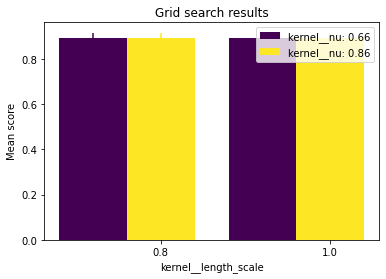

In [46]:
with open("Results/gs_clf.dump" , "rb") as f:
    clf_loaded = pickle.load(f)

plot.grid_search(clf_loaded.cv_results_, change='kernel__length_scale', kind='bar')


In [5]:
gpr.get_params()

{'alpha': 0.15,
 'copy_X_train': True,
 'kernel__length_scale': 1.0,
 'kernel__length_scale_bounds': (1e-05, 100000.0),
 'kernel__nu': 0.66,
 'kernel': Matern(length_scale=1, nu=0.66),
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': 0}

In [25]:
param_grid = [
  {'alpha': [1e-5, 0.0001, 0.001, 0.01, 0.1], 'kernel__nu':[0.66, 0.86]},
 ]

In [26]:
gpr_ps = GaussianProcessRegressor(kernel = Matern(nu=0.66))
clf = GridSearchCV(estimator=gpr_ps,
             param_grid=param_grid)
clf.fit(X, y)

/usr/local/anaconda3/envs/LBNL/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/envs/LBNL/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/usr/local/anaconda3/envs/LBNL/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

GridSearchCV(estimator=GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=0.66)),
             param_grid=[{'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                          'kernel__nu': [0.66, 0.86]}])

<AxesSubplot:title={'center':'Grid search results'}, xlabel='alpha', ylabel='Mean score'>

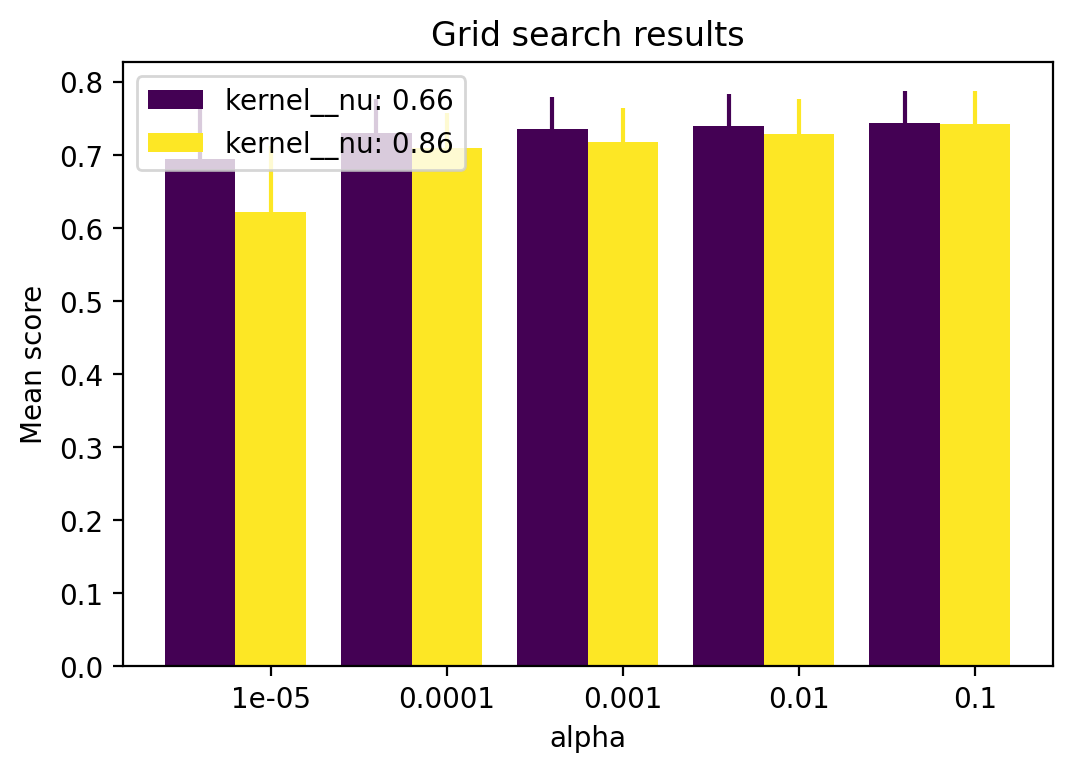

In [27]:
plot.grid_search(clf.cv_results_, change='alpha', kind='bar')

In [5]:
# Matern nu tuning
# cv_score = []
# nus = np.linspace(0.4, 2.6, 3)
# relu = lambda x: x if x>0 else 0
# for nu in nus:
#     kernel = Matern(nu=nu)
#     gpr = GaussianProcessRegressor(kernel=kernel,random_state=0, alpha=alpha).fit(venus.X_train, venus.y_train)
#     cvs = cross_val_score(gpr, X, y)
#     avg_cvs = sum(cvs)/len(cvs)
#     print("%f for nu=%f"%(avg_cvs, nu))
#     cv_score.append(avg_cvs)

# cv_score = [relu(x) for x in cv_score]
# plt.plot(nus, cv_score, label="Cross-Validation Score")
# plt.legend()
# plt.xlabel("nu")
# plt.title("Matern Kernel (alpha = 0.15)")
# plt.savefig("Matern nu.png")

In [6]:
# use all available data for the final model
kernel = Matern(nu=0.66)

venus_whole = MyDataset()
venus_whole.load_split(X, y, test_ratio=0)
venus_whole.populate(X, None, y, None)
venus_whole.normalize()

gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))

dataset normalized!
Whole dataset training score: 0.972226


In [7]:
# save the model and print the normalizing lists used
with open("Models/gprMatern0.66.dump" , "wb") as f:
    pickle.dump(gpr, f)
print(venus_whole.avg_list, venus_whole.std_list)

[102.52640418 104.08696283 122.59401936] [3.34305675 3.45653727 3.00584971]


In [8]:
def denormalize_gpr(gpr, dataset):
    """Denormalize and unpack gpr into a mean function and a variance function. """
    def gauss_mean(x, y, z):
        arr = np.array([[x,y,z]])
        arr = dataset.normalize_vec(arr)
        result = gpr.predict(arr)
        return result
    
    def gauss_var(x, y, z):
        arr = np.array([[x,y,z]])
        arr = dataset.normalize_vec(arr)
        result = gpr.predict(arr, return_std=True)[1]
        return result
    return gauss_mean, gauss_var

In [9]:
gauss_mean, gauss_var = denormalize_gpr(gpr, venus_whole)

z_values = np.linspace(117, 130, 27)
plot_4D(gauss_mean, z_values, "Figures/GPRplots/mean_refact/", color_num = 21, wbounds=(0, 170))
# plot_4D(gauss_var, z_values, "Figures/GPRplots/var_refact/", color_num = 21, wbounds=(0, 1))

'Cross Sections.gif'

In [10]:
plot_4D_CS(gauss_mean, 126, wbounds=(0, 170))
plot_4D(gauss_mean, z_values, func_name="test",save_images=False, color_num = 21, wbounds=(0, 170))

'test.gif'

# Compare the Normalized Results of the two runs

In [11]:
# train two models

def train_model_on_run(data_dir):
    X, y = loadXy(data_dir)
    venus_whole = MyDataset()
    venus_whole.populate(X, None, y, None)
    venus_whole.normalize()

    kernel = Matern(nu=0.66)
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=1, alpha=alpha).fit(venus_whole.X_train, venus_whole.y_train)
    print("Whole dataset training score: %f"%gpr.score(venus_whole.X_train, venus_whole.y_train))
    return gpr, venus_whole

gpr1, venus1 = train_model_on_run("Data/data1.pkl")
gpr2, venus2 = train_model_on_run("Data/data2.pkl")

dataset normalized!
Whole dataset training score: 0.972426
dataset normalized!
Whole dataset training score: 0.956383


In [12]:
# for z in np.linspace(117, 130, 27):
#     plot_cross_section(gpr1, z, dataset=venus1, plotVar=True)
#     plot_cross_section(gpr1, z, dataset=venus1, plotVar=False)

In [13]:
filenames1 = []
filenames2 = []
for z in np.linspace(117, 130, 27):
    filenames1.append(plot_cross_section(gpr2, z, dataset=venus2, plotVar=True))
    filenames2.append(plot_cross_section(gpr2, z, dataset=venus2, plotVar=False, z_ratio=0.87)) # , 
    

with imageio.get_writer('mygif.gif', mode='I') as writer:
    for filename in filenames1:
        image = imageio.imread(filename)
        writer.append_data(image)

NameError: name 'plot_cross_section' is not defined